#### For Data collection please refer to Data_Collection.ipynb notebook

In [30]:
# Import necessary libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from time import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_parquet("nlp_stackoverflow_all_combined.parquet")
df

,title,description,tags,source_tag,question_id,view_count,creation_date,creation_timestamp,accepted_answer
0,Methods for Geotagging or Geolabelling Text Co...,<p>What are some good algorithms for automatic...,algorithm;statistics;nlp;named-entity-recognition,ner,163923,6591,2008-10-02 18:44:32,1222973072,"<p>You're looking for a <a href=""https://secur..."
1,Named Entity Recognition Libraries for Java,"<p>I am looking for a simple but ""good enough""...",java;nlp;named-entity-recognition,ner,188176,23783,2008-10-09 16:54:54,1223571294,"<p>BTW, I recently ran across <a href=""http://..."
2,Algorithms recognizing physical address on a w...,<p>What are the best algorithms for recognizin...,algorithm;screen-scraping;nlp;pattern-matching...,ner,348958,4565,2008-12-08 09:06:36,1228727196,<p>A named-entity extraction framework such as...
3,Strategies for recognizing proper nouns in NLP,<p>I'm interested in learning more about <a hr...,nlp;named-entity-recognition;part-of-speech,ner,608743,9094,2009-03-03 23:56:45,1236124605,<p>The task of determining the proper part of ...
4,Algorithms for named entity recognition,<p>I would like to use named entity recognitio...,php;python;extract;analysis;named-entity-recog...,ner,1026925,10001,2009-06-22 12:26:33,1245673593,"<p>To start with check out <a href=""http://www..."
...,...,...,...,...,...,...,...,...,...
27778,Can&#39;t get UUID from similarity search Weav...,<p>I tried to retrieve documents with similar ...,python;langchain;vector-database;weaviate,langchain,79467575,93,2025-02-25 18:37:20,1740508640,<p>Duda Nogueira from Weaviate here!</p>\n<p>C...
27779,When using &#39;interrupt&#39; followed by &#3...,<p>When I invoke a graph that includes <code>i...,javascript;langchain;langgraph,langchain,79471648,287,2025-02-27 05:09:58,1740632998,"<p>I'm an engineer on the LangChain team, and ..."
27780,Precision used in ChromaDB Index,<p>I am using BAAI/bge-large-en-v1.5 model to ...,langchain;embedding;dtype;chromadb;vector-data...,langchain,79473655,21,2025-02-27 18:50:31,1740682231,<p>like this:</p>\n<pre><code>import chromadb\...
27781,Presidio with Langchain Experimental does not ...,<p>I am using presidio/langchain_experimental ...,python;nlp;spacy;langchain;presidio,langchain,79482283,229,2025-03-03 22:27:07,1741040827,<p>After some test I was able to find the solu...


In [3]:
# Lets check if any questions are repeating --> no

df['question_id'].nunique()

27783

In [4]:
# Sort the DataFrame by view_count in descending order without creating a new DataFrame

df.sort_values(by='view_count', ascending=False, inplace=True)
df = df.reset_index(drop=True)
df

,title,description,tags,source_tag,question_id,view_count,creation_date,creation_timestamp,accepted_answer
0,Parse (split) a string in C++ using string del...,<p>I am parsing a string in C++ using the foll...,c++;parsing;split;token;tokenize,tokenization,14265581,2446886,2013-01-10 19:16:43,1357845403,"<p>You can use the <a href=""http://en.cpprefer..."
1,What is the easiest/best/most correct way to i...,<p>Some ways to iterate through the characters...,java;string;iteration;character;tokenize,tokenization,196830,736770,2008-10-13 06:10:15,1223878215,"<p>As far as correctness goes, this only works..."
2,How do I tokenize a string in C++?,<p>Java has a convenient split method:</p>\n\n...,c++;string;split;tokenize,tokenization,53849,672316,2008-09-10 12:10:25,1221048625,<p>C++ standard library algorithms are pretty ...
3,re.sub erroring with &quot;Expected string or ...,<p>I have read multiple posts regarding this e...,python;pandas;regex;typeerror;nltk,nltk,43727583,555820,2017-05-01 22:47:19,1493678839,"<p>As you stated in the comments, some of the ..."
4,How to split a string in shell and get the las...,<p>Suppose I have the string <code>1:2:3:4:5</...,bash;split;tokenize;cut,tokenization,3162385,544637,2010-07-01 23:29:38,1278026978,"<p>You can use <a href=""http://www.linuxjourna..."
...,...,...,...,...,...,...,...,...,...
27778,"nltk, cannot classify info into class","<p>Need help with this, i have run codes below...",python;text;nltk,nltk,74210817,18,2022-10-26 15:58:49,1666799929,<p>Comparision</p>\n<pre><code>news2.Class==&q...
27779,how to do custom grouping of aggregations?,<p>lets say I have a bunch of aggregation like...,elasticsearch,elasticsearch,79251531,17,2024-12-04 14:19:49,1733321989,<p>So the closest I could get is to create sub...
27780,"Infer &quot;shapes&quot;, or infer analogous r...",<p>Gensim Word2Vec offers a system for inferri...,gensim;word2vec,gensim,72165998,17,2022-05-09 00:40:06,1652056806,<p>There's no built-in facility resembling wha...
27781,How to add a user prompt to approve a list of ...,<p>I have a python script where I log into Ela...,python;elasticsearch;prompt,elasticsearch,78410512,15,2024-04-30 18:46:25,1714502785,"<pre><code>def indices_delete(configuration, e..."


In [5]:
df =df[["title","description","tags","accepted_answer","creation_date","view_count"]].copy()

In [6]:
# Split tags and stack them to create one row per tag
all_tags = df.tags.str.split(';').explode()

# Count occurrences of each tag
tag_counts = all_tags.value_counts().sort_values(ascending=False)

# how many unique tags do we have in total
len(tag_counts)

4384

In [7]:
# What are the top 50 recurring tags -> NLP and related

tag_counts[:50]

tags
python                      10203
nlp                          6171
elasticsearch                4651
nltk                         3304
speech-recognition           1845
tokenize                     1674
java                         1643
spacy                        1627
machine-learning             1600
python-3.x                   1398
text-to-speech               1361
r                            1300
chatbot                      1271
text-mining                  1181
tensorflow                   1144
gensim                       1105
keras                        1035
stanford-nlp                 1023
word2vec                      955
android                       945
lstm                          922
pandas                        887
c#                            831
regex                         749
speech-to-text                720
deep-learning                 687
sentiment-analysis            677
scikit-learn                  674
pytorch                       648
text-clas

In [8]:
# lets remove html tags from description and accepted_answer
from bs4 import BeautifulSoup
from bs4 import MarkupResemblesLocatorWarning
import re
import warnings
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
df['title'] = df['title'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
df['description'] = df['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
df['accepted_answer'] = df['accepted_answer'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

In [9]:
df["text"] = "<title>" + df["title"] + "</title>" + "\n" \
"<description>" + df["description"] + "</description>" + "\n" \
"<answer>" + df["accepted_answer"] + "</answer>"

In [10]:
df.drop(columns=["title","description","accepted_answer","tags"], inplace=True)

In [11]:
print(df['text'][3])

<title>re.sub erroring with "Expected string or bytes-like object"</title>
<description>I have read multiple posts regarding this error, but I still can't figure it out. When I try to loop through my function:
def fix_Plan(location):
    letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          location)     # Column and row to search    

    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return (" ".join(meaningful_words))

col_Plan = fix_Plan(train["Plan"][0])
num_responses = train["Plan"].size
clean_Plan_responses = []

for i in range(0,num_responses):
    clean_Plan_responses.append(fix_Plan(train["Plan"][i]))

Here is the error:
Traceback (most recent call last):
  File "C:/Users/xxxxx/PycharmProjects/tronc/tronc2.py", line 48, in <module>
    clean_Plan_responses.append(fix

In [12]:
# Now lets apply all pre-processing steps to the text
# lets also lemmatize the text and remove stop words
# Import necessary libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    return text

# Apply preprocessing to the text column
df['processed_text'] = df['text'].apply(preprocess_text)

In [13]:
df

,creation_date,view_count,text,processed_text
0,2013-01-10 19:16:43,2446886,<title>Parse (split) a string in C++ using str...,title parse split string c using string delimi...
1,2008-10-13 06:10:15,736770,<title>What is the easiest/best/most correct w...,title easiest best correct way iterate charact...
2,2008-09-10 12:10:25,672316,<title>How do I tokenize a string in C++?</tit...,title tokenize string c title description java...
3,2017-05-01 22:47:19,555820,"<title>re.sub erroring with ""Expected string o...",title sub erroring expected string byte like o...
4,2010-07-01 23:29:38,544637,<title>How to split a string in shell and get ...,title split string shell get last field title ...
...,...,...,...,...
27778,2022-10-26 15:58:49,18,"<title>nltk, cannot classify info into class</...",title nltk cannot classify info class title de...
27779,2024-12-04 14:19:49,17,<title>how to do custom grouping of aggregatio...,title custom grouping aggregation title descri...
27780,2022-05-09 00:40:06,17,"<title>Infer ""shapes"", or infer analogous rela...",title infer shape infer analogous relation wor...
27781,2024-04-30 18:46:25,15,<title>How to add a user prompt to approve a l...,title add user prompt approve list index delet...


In [14]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

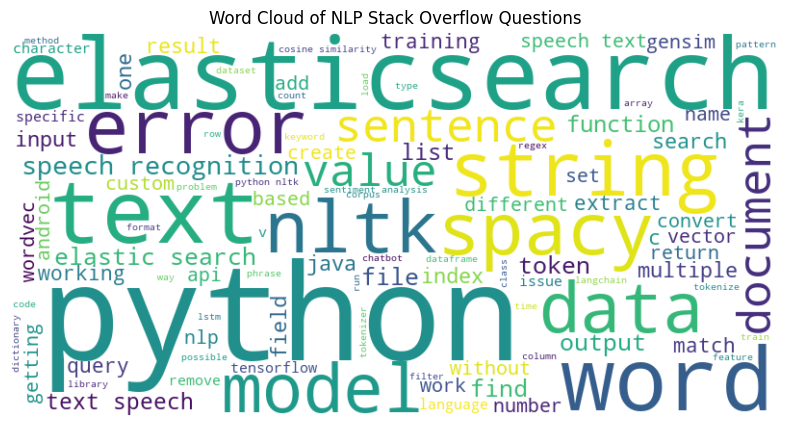

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract titles for the word cloud
titles = df['text'].str.extract(r'<title>(.*?)</title>', expand=False)

# Preprocess titles
processed_titles = titles.apply(preprocess_text)

# Join all processed titles
all_titles_text = ' '.join(processed_titles)

# Tokenize and remove stopwords
title_tokens = tokenize_text(all_titles_text)
filtered_title_text = ' '.join(title_tokens)

# Lets remove some additional words from the word cloud
additional_words = ['using','use','and']
filtered_title_text = ' '.join([word for word in filtered_title_text.split() if word not in additional_words])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(filtered_title_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of NLP Stack Overflow Questions')
plt.show()

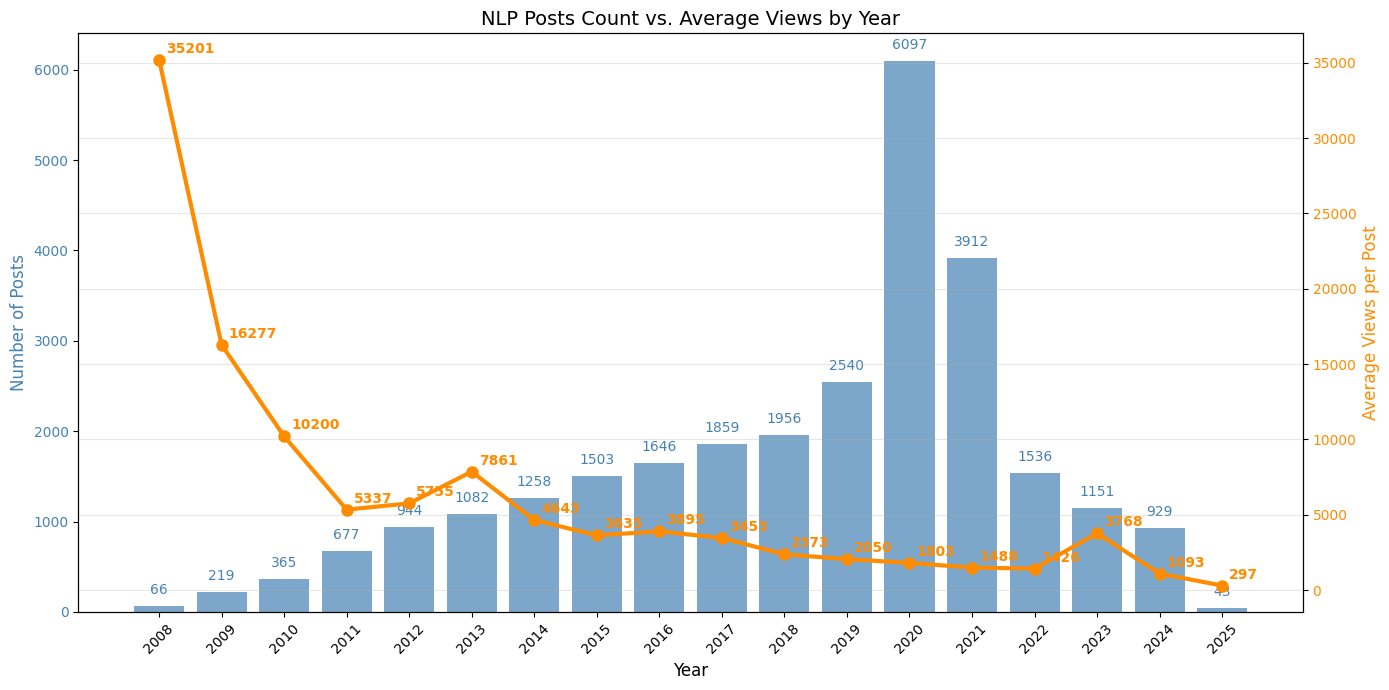

In [17]:
# Extract year from creation_date
df['year'] = pd.to_datetime(df['creation_date']).dt.year

yearly_views = df.groupby('year')['view_count'].agg(['sum', 'mean', 'count'])
yearly_views = yearly_views.sort_index()

#Dual-axis chart: Post count and average views
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the number of posts (bar chart)
color = 'steelblue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Posts', color=color, fontsize=12)
bars = ax1.bar(yearly_views.index, yearly_views['count'], color=color, alpha=0.7)

# Add post counts on top of bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 100,
            f'{int(height)}',
            ha='center', va='bottom', rotation=0, color=color)

ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for average views (line chart)
ax2 = ax1.twinx()
color = 'darkorange'
ax2.set_ylabel('Average Views per Post', color=color, fontsize=12)
line = ax2.plot(yearly_views.index, yearly_views['mean'], color=color, 
         linewidth=3, marker='o', markersize=8)

# Add average view values next to line points
for x, y in zip(yearly_views.index, yearly_views['mean']):
    ax2.annotate(f'{int(y)}', 
                xy=(x, y), 
                xytext=(5, 5),
                textcoords='offset points',
                color=color,
                fontweight='bold')

ax2.tick_params(axis='y', labelcolor=color)

# Set title and format
plt.title('NLP Posts Count vs. Average Views by Year', fontsize=14)

# Set x-ticks to be exactly at the year values
ax1.set_xticks(yearly_views.index)
ax1.set_xticklabels(yearly_views.index.astype(int), rotation=45)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
df.drop(columns=["creation_date","view_count","year"], inplace=True)

#### Categorize the data
#### Approach 1 - Most Straightforward: Regex-based categorization

Implementation Issues: 5525 posts
Understanding Issues: 582 posts
Text Similarity: 680 posts
Tokenization: 233 posts
Stemming/Lemmatization: 55 posts
Language Identification: 36 posts
SpaCy: 1247 posts
NLTK: 1533 posts
Hugging Face/Transformers: 713 posts
Gensim: 678 posts
Word2Vec: 650 posts
FastText: 135 posts
LDA/Topic Modeling: 189 posts


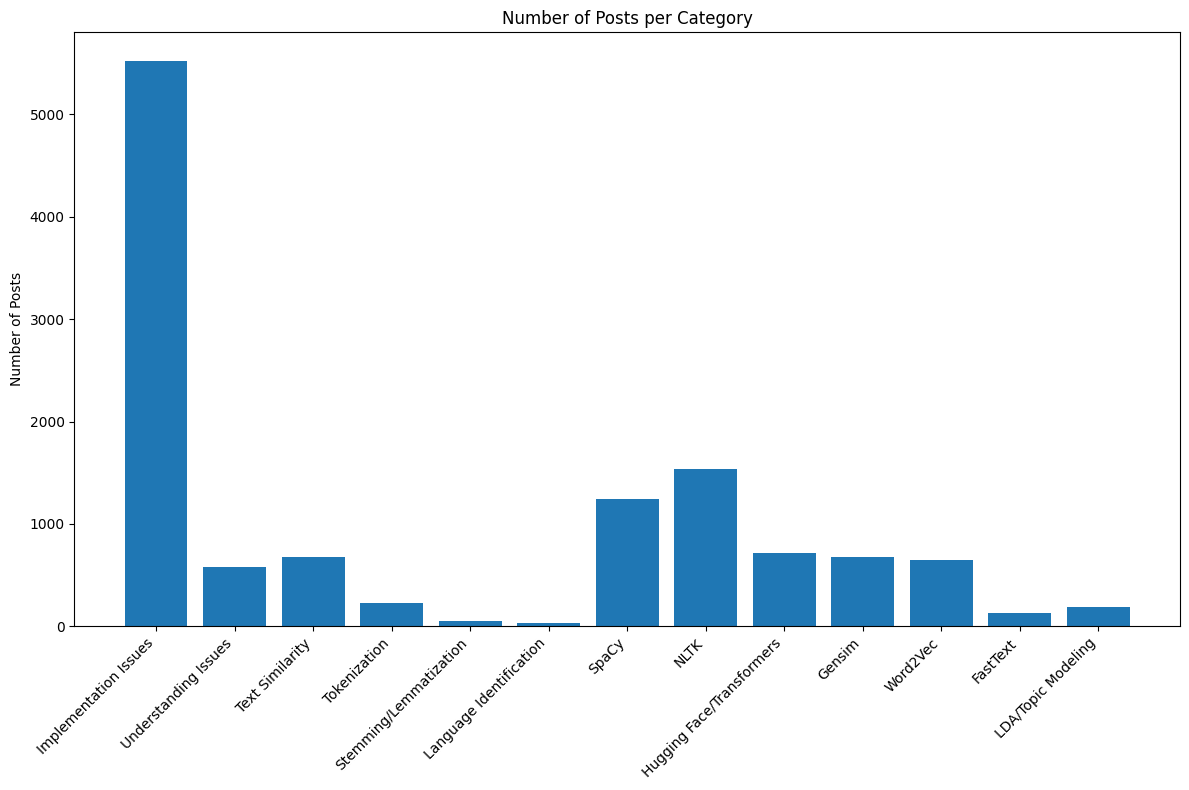

In [59]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

def categorize_posts(df):
    # Initialize category columns
    df['implementation_issues'] = False
    df['understanding_issues'] = False
    df['task_text_similarity'] = False
    df['task_tokenization'] = False
    df['task_stemming_lemmatization'] = False
    df['task_language_identification'] = False
    df['library_spacy'] = False
    df['library_nltk'] = False
    df['library_huggingface'] = False
    df['library_gensim'] = False
    df['library_word2vec'] = False
    df['library_fasttext'] = False
    df['library_lda'] = False
    
    # Regex patterns for categorization
    implementation_pattern = r'(?i)<title>.*?\b(how to|how can|implement|implementation)\b.*?</title>'
    understanding_pattern = r'(?i)<title>.*?\b(what is|what are|mean|meaning|define|definition)\b.*?</title>'
    text_similarity_pattern = r'(?i)<title>.*?\b(similar|similarity|compare|comparison)\b.*?</title>'
    tokenization_pattern = r'(?i)<title>.*?\b(tokeniz|tokenis|token)\b.*?</title>'
    stemming_pattern = r'(?i)<title>.*?\b(stem|lemmatiz|lemma)\b.*?</title>'
    language_id_pattern = r'(?i)<title>.*?\b(language detection|language identification|identify language|detect language)\b.*?</title>'
    
    # Library patterns
    spacy_pattern = r'(?i)<title>.*?\b(spacy|spacey)\b.*?</title>'
    nltk_pattern = r'(?i)<title>.*?\b(nltk)\b.*?</title>'
    huggingface_pattern = r'(?i)<title>.*?\b(huggingface|transformers|bert|gpt|roberta)\b.*?</title>'
    gensim_pattern = r'(?i)<title>.*?\b(gensim)\b.*?</title>'
    word2vec_pattern = r'(?i)<title>.*?\b(word2vec|word embedding|word vector)\b.*?</title>'
    fasttext_pattern = r'(?i)<title>.*?\b(fasttext)\b.*?</title>'
    lda_pattern = r'(?i)<title>.*?\b(lda|topic model|latent dirichlet)\b.*?</title>'
    
    # Apply categorization
    df['implementation_issues'] = df['text'].str.contains(implementation_pattern, regex=True)
    df['understanding_issues'] = df['text'].str.contains(understanding_pattern, regex=True)
    df['task_text_similarity'] = df['text'].str.contains(text_similarity_pattern, regex=True)
    df['task_tokenization'] = df['text'].str.contains(tokenization_pattern, regex=True)
    df['task_stemming_lemmatization'] = df['text'].str.contains(stemming_pattern, regex=True)
    df['task_language_identification'] = df['text'].str.contains(language_id_pattern, regex=True)
    
    df['library_spacy'] = df['text'].str.contains(spacy_pattern, regex=True)
    df['library_nltk'] = df['text'].str.contains(nltk_pattern, regex=True)
    df['library_huggingface'] = df['text'].str.contains(huggingface_pattern, regex=True)
    df['library_gensim'] = df['text'].str.contains(gensim_pattern, regex=True)
    df['library_word2vec'] = df['text'].str.contains(word2vec_pattern, regex=True)
    df['library_fasttext'] = df['text'].str.contains(fasttext_pattern, regex=True)
    df['library_lda'] = df['text'].str.contains(lda_pattern, regex=True)
    
    return df

# Apply categorization
categorized_df = categorize_posts(df)

# Count posts in each category
category_counts = {
    'Implementation Issues': categorized_df['implementation_issues'].sum(),
    'Understanding Issues': categorized_df['understanding_issues'].sum(),
    'Text Similarity': categorized_df['task_text_similarity'].sum(),
    'Tokenization': categorized_df['task_tokenization'].sum(),
    'Stemming/Lemmatization': categorized_df['task_stemming_lemmatization'].sum(),
    'Language Identification': categorized_df['task_language_identification'].sum(),
    'SpaCy': categorized_df['library_spacy'].sum(),
    'NLTK': categorized_df['library_nltk'].sum(),
    'Hugging Face/Transformers': categorized_df['library_huggingface'].sum(),
    'Gensim': categorized_df['library_gensim'].sum(),
    'Word2Vec': categorized_df['library_word2vec'].sum(),
    'FastText': categorized_df['library_fasttext'].sum(),
    'LDA/Topic Modeling': categorized_df['library_lda'].sum()
}

# Print category counts
for category, count in category_counts.items():
    print(f"{category}: {count} posts")

# Visualize categories
plt.figure(figsize=(12, 8))
plt.bar(category_counts.keys(), category_counts.values())
plt.xticks(rotation=45, ha='right')
plt.title('Number of Posts per Category')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()

# Save categorized posts for each category
for category_col in [col for col in categorized_df.columns if col not in ['text', 'processed_text']]:
    category_name = category_col.replace('_', ' ').title()
    category_posts = categorized_df[categorized_df[category_col]]
    
    if len(category_posts) >= 10:
        filename = f"{category_col}_posts.csv"
        # Extract original components for better readability in CSV
        category_posts['title'] = category_posts['text'].str.extract(r'<title>(.*?)</title>', expand=False)
        category_posts['description'] = category_posts['text'].str.extract(r'<description>(.*?)</description>', expand=False)
        category_posts['answer'] = category_posts['text'].str.extract(r'<answer>(.*?)</answer>', expand=False)
        
        # Save to CSV
        # category_posts[['title', 'description', 'answer']].to_csv(filename, index=False)
        # print(f"Saved {len(category_posts)} posts to {filename}")

### Approach 2 - K-Means and LDA

In [32]:
# Lets take 5000 sample data for the comparison analysis
sample_size = 5000
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

print(f"Data sample shape: {df_sample.shape}")

Data sample shape: (5000, 15)


#### Vectorization

In [33]:
# 1. We use TF-IDF Vectorizer for K-means because it is more suitable for clustering tasks where the frequency of terms matters.
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=5,
    max_df=0.5,
    ngram_range=(1, 2)
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df_sample['processed_text'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# 2. We use Count Vectorizer for LDA because LDA is a generative model that assumes a bag-of-words representation of the documents.
count_vectorizer = CountVectorizer(
    max_features=1000,
    min_df=5,
    max_df=0.5,
    ngram_range=(1, 2)
)
count_matrix = count_vectorizer.fit_transform(df_sample['processed_text'])
print(f"Count matrix shape: {count_matrix.shape}")

TF-IDF matrix shape: (5000, 1000)
Count matrix shape: (5000, 1000)


#### Topic coherence and evaluation metrics


In [34]:
# We create 2 helper functions to calculate the coherence score for LDA and KMeans and print the top words for each topic/cluster.

# Function to calculate topic coherence (based on word co-occurrence)
def calculate_coherence(model, term_matrix, feature_names, n_top_words=10):
    coherence_scores = []
    doc_term_matrix = term_matrix.toarray()
    
    # Get top words for each topic
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        coherence = 0
        
        # Calculate pairwise co-occurrence for top words
        for i, word_i in enumerate(top_words_idx[:-1]):
            for word_j in top_words_idx[i+1:]:
                # Count documents where both words appear
                w_i_docs = doc_term_matrix[:, word_i] > 0
                w_j_docs = doc_term_matrix[:, word_j] > 0
                both = np.sum(w_i_docs & w_j_docs)
                
                # Avoid log(0)
                if both > 0:
                    coherence += np.log((both + 1) / np.sum(w_i_docs))
        
        coherence_scores.append(coherence)
    
    return np.mean(coherence_scores)

# Function to print top words for each topic/cluster
def print_top_words(components, feature_names, n_top_words=10):
    result = []
    for idx, component in enumerate(components):
        top_words_idx = component.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        result.append(f"#{idx + 1}: {', '.join(top_words)}")
    return result

#### Run LDA with different number of topics

In [41]:
# LDA Topic Modeling Evaluation
n_topics_range = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
lda_results = {}

for n_topics in n_topics_range:
    print(f"Training LDA with {n_topics} topics")
    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=10,
        learning_method='online',
        random_state=42,
        batch_size=128,
        n_jobs=-1
    )
    
    start_time = time()
    lda_model.fit(count_matrix)
    train_time = time() - start_time
    
    # We Calculate perplexity
    perplexity = lda_model.perplexity(count_matrix)
    
    # We Calculate coherence
    coherence = calculate_coherence(lda_model, count_matrix, count_vectorizer.get_feature_names_out())
    
    # We get the topic distributions
    lda_output = lda_model.transform(count_matrix)
    
    # We get topic summaries
    feature_names = count_vectorizer.get_feature_names_out()
    topic_summaries = print_top_words(lda_model.components_, feature_names)
    
    lda_results[n_topics] = {
        'model': lda_model,
        'perplexity': perplexity,
        'coherence': coherence,
        'train_time': train_time,
        'topic_summaries': topic_summaries
    }
    
    print(f"Perplexity: {perplexity:.2f}")
    print(f"Coherence: {coherence:.2f}")
    print(f"Training time: {train_time:.2f} seconds")
    print("Sample topics:")
    for i in range(min(3, n_topics)):
        print(f"# {topic_summaries[i]}")

Training LDA with 5 topics
Perplexity: 426.90
Coherence: -57.07
Training time: 23.33 seconds
Sample topics:
# #1: model, word, vector, data, document, text, train, label, feature, training
# #2: model, self, input, size, layer, train, output, none, shape, py
# #3: type, index, query, field, id, doc, search, elasticsearch, name, value
Training LDA with 10 topics
Perplexity: 367.81
Coherence: -60.03
Training time: 18.94 seconds
Sample topics:
# #1: model, vector, word, train, training, data, feature, label, wordvec, tokenizer
# #2: java, elasticsearch, org, node, index, cluster, http, name, client, data
# #3: type, query, field, index, id, doc, count, search, value, name
Training LDA with 15 topics
Perplexity: 349.99
Coherence: -70.99
Training time: 22.98 seconds
Sample topics:
# #1: model, vector, word, training, document, train, tokenizer, data, wordvec, label
# #2: self, java, org, state, torch, apache, hidden, class, def, org apache
# #3: new, string, public, tt, android, void, speec

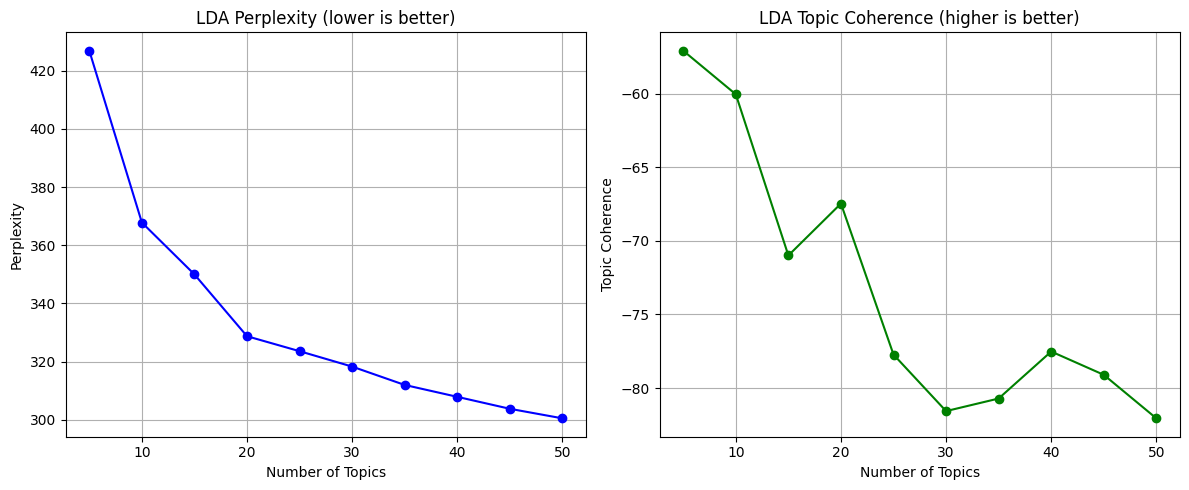

In [42]:
# Plot LDA evaluation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot([k for k in n_topics_range], [lda_results[k]['perplexity'] for k in n_topics_range], 'o-', color='blue')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('LDA Perplexity (lower is better)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot([k for k in n_topics_range], [lda_results[k]['coherence'] for k in n_topics_range], 'o-', color='green')
plt.xlabel('Number of Topics')
plt.ylabel('Topic Coherence')
plt.title('LDA Topic Coherence (higher is better)')
plt.grid(True)

plt.tight_layout()
plt.show()

☝️
#### Left Graph: Perplexity (Lower perplexity indicates better fit)
- **Definition**: Perplexity measures how well the model predicts the data. 
- **Trend**: The graph shows a consistently decreasing trend as the number of topics increases.
- **Interpretation**: Adding more topics consistently improves the model's ability to predict the data.
- **Conclusion**: Based on just perplexity, more topics lead to a better model.

#### Right Graph: Topic Coherence (Higher values indicate more coherent, interpretable topics)
- **Definition**: Topic coherence evaluates how semantically coherent the topics are.
- **Trend**: Coherence decreases from 5 to 15 topics, with a recovery at 20 topics.
- **Interpretation**: Fewer topics generally produce more coherence than more topics.
- **Conclusion**: Having fewer topics makes the model more interpretable.

#### Final Conclusion
We want to optimize for both lower perplexity and higher coherence. Given the improvement in coherence at 20 topics combined with the continued improvement in perplexity, 20 topics appears to be the optimal selection, offering a good balance between model fit and interpretability.

In [43]:
# so lets understand top 20 topics picked by LDA

lda_results[20]

{'model': LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                           random_state=42),
 'perplexity': np.float64(328.72871535842705),
 'coherence': np.float64(-67.46127532007212),
 'train_time': 20.854531049728394,
 'topic_summaries': ['#1: model, train, tokenizer, label, id, data, import, dataset, vocab, training',
  '#2: self, size, none, batch, loss, def, state, embedding, output, max',
  '#3: new, public, string, tt, android, void, system, speech, class, intent',
  '#4: string, match, name, text, list, pattern, regex, map, character, split',
  '#5: model, input, layer, tf, train, shape, test, kera, lstm, output',
  '#6: word, sentence, list, nltk, import, print, text, tokenize, similarity, word word',
  '#7: df, column, data, row, dataframe, csv, text, pd, panda, import',
  '#8: count, doc, key, doc count, term, topic, aggregation, min, size, value',
  '#9: text, like, would, want, need, way, example, one, work, also',
  '#10: token, 

☝️
(Manually classified based on domain understanding)

#### 20 LDA Topics from Stack Overflow NLP Questions

1. **NLP Model Training & Datasets**: model, train, tokenizer, label, id, data, import, dataset, vocab, training
2. **Deep Learning Implementation**: self, size, none, batch, loss, def, state, embedding, output, max
3. **Android & Speech Processing**: new, public, string, tt, android, void, system, speech, class, intent
4. **String Manipulation & Regex**: string, match, name, text, list, pattern, regex, map, character, split
5. **TensorFlow & Keras Models**: model, input, layer, tf, train, shape, test, kera, lstm, output
6. **NLTK Text Processing**: word, sentence, list, nltk, import, print, text, tokenize, similarity, word word
7. **Pandas for NLP**: df, column, data, row, dataframe, csv, text, pd, panda, import
8. **Document Statistics**: count, doc, key, doc count, term, topic, aggregation, min, size, value
9. **General Inquiries**: text, like, would, want, need, way, example, one, work, also
10. **String Tokenization**: token, string, return, int, line, input, end, function, length, char
11. **File Processing**: file, line, path, txt, import, nltk, data, open, read, json
12. **spaCy Usage**: spacy, nlp, doc, entity, en, component, text, span, token, label
13. **Language Resources**: language, com, http, github, config, color, github com, http github, en, english
14. **Text Classification**: corpus, feature, score, document, sentiment, data, tweet, matrix, term, classifier
15. **Elasticsearch**: elasticsearch, java, org, index, node, data, http, cluster, name, client
16. **Word Embeddings**: vector, word, document, wordvec, one, time, training, gensim, number, set
17. **POS Tagging & Parsing**: tag, po, stanford, tree, sentence, nltk, np, nn, nlp, parser
18. **Search Queries**: type, query, field, index, id, search, keyword, value, name, filter
19. **Speech APIs & Chatbots**: speech, audio, api, recognition, response, user, var, bot, http, url
20. **Python Environment**: py, python, error, file, line, py line, lib, package, module, install

##### Analysis: The 20-topic LDA model effectively captures the diversity of NLP questions on Stack Overflow, spanning core NLP tasks, infrastructure and tools, deep learning implementations, specific libraries, and real-world applications. With a perplexity of 328.73 and coherence of -67.46, this model balances fit and interpretability.

### K-means with different number of clusters

In [44]:
# K-means Clustering Evaluation

k_range = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
kmeans_results = {}

# Normalize the TF-IDF matrix for K-means
X_normalized = normalize(tfidf_matrix)

for k in k_range:
    print(f"Training K-means with k={k}")
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=42)
    
    start_time = time()
    kmeans.fit(X_normalized)
    train_time = time() - start_time
    
    labels = kmeans.labels_
    
    # Calculate evaluation metrics
    silhouette = silhouette_score(X_normalized, labels)
    db = davies_bouldin_score(X_normalized.toarray(), labels)
    ch = calinski_harabasz_score(X_normalized.toarray(), labels)
    
    # Calculate inertia (within-cluster sum of squares)
    inertia = kmeans.inertia_
    
    # Get cluster summaries
    feature_names = tfidf_vectorizer.get_feature_names_out()
    cluster_summaries = print_top_words(kmeans.cluster_centers_, feature_names)
    
    # Store results
    kmeans_results[k] = {
        'model': kmeans,
        'silhouette': silhouette,
        'db': db,
        'ch': ch,
        'inertia': inertia,
        'train_time': train_time,
        'cluster_summaries': cluster_summaries
    }
    
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {db:.4f}")
    print(f"Calinski-Harabasz Index: {ch:.4f}")
    print(f"Training time: {train_time:.2f} seconds")
    print("Sample clusters:")
    for i in range(min(3, k)):
        print(f"# {cluster_summaries[i]}")

Training K-means with k=5
Silhouette Score: 0.0221
Davies-Bouldin Index: 5.9393
Calinski-Harabasz Index: 67.7143
Training time: 0.59 seconds
Sample clusters:
# #1: speech, voice, recognition, audio, tt, speech recognition, android, text, texttospeech, speak
# #2: word, nltk, sentence, text, list, token, tokenize, import, corpus, df
# #3: text, file, string, token, data, spacy, name, document, elasticsearch, nlp
Training K-means with k=10
Silhouette Score: 0.0264
Davies-Bouldin Index: 5.1575
Calinski-Harabasz Index: 51.1970
Training time: 0.99 seconds
Sample clusters:
# #1: query, field, type, search, index, id, keyword, term, doc, name
# #2: model, layer, input, lstm, train, shape, tf, self, loss, size
# #3: spacy, nlp, doc, token, en, en core, entity, core web, core, matcher
Training K-means with k=15
Silhouette Score: 0.0300
Davies-Bouldin Index: 4.9950
Calinski-Harabasz Index: 43.4419
Training time: 1.44 seconds
Sample clusters:
# #1: nltk, tag, po, word, sentence, synset, import, p

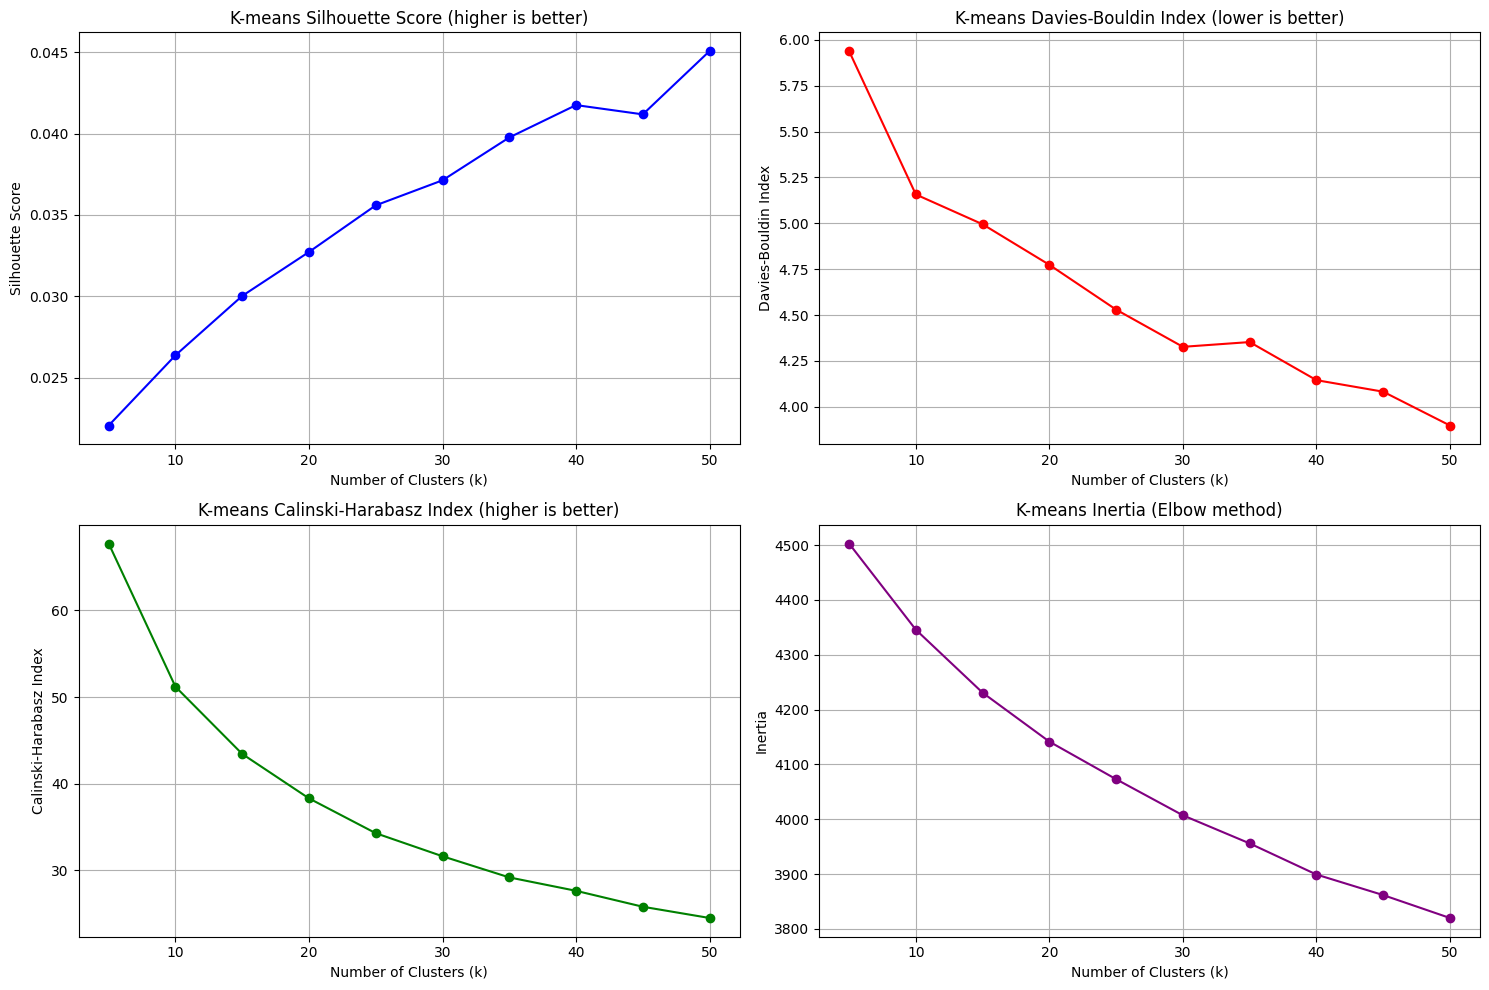

In [45]:
# Plot K-means evaluation metrics
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot([k for k in k_range], [kmeans_results[k]['silhouette'] for k in k_range], 'o-', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('K-means Silhouette Score (higher is better)')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot([k for k in k_range], [kmeans_results[k]['db'] for k in k_range], 'o-', color='red')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('K-means Davies-Bouldin Index (lower is better)')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot([k for k in k_range], [kmeans_results[k]['ch'] for k in k_range], 'o-', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('K-means Calinski-Harabasz Index (higher is better)')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot([k for k in k_range], [kmeans_results[k]['inertia'] for k in k_range], 'o-', color='purple')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('K-means Inertia (Elbow method)')
plt.grid(True)

plt.tight_layout()
plt.show()

☝️
### K-means Clustering Evaluation Metrics Analysis

#### Top Left Graph
**Silhouette Score (Higher values indicate better-defined clusters)**
- **Definition**: Measures how well-separated the clusters are
- **Trend**: Consistently increases as k increases, with the highest value at k=50
- **Interpretation**: The clustering quality improves with more clusters
- **Conclusion**: Data has many natural groupings

#### Top Right Graph
**Davies-Bouldin Index (Lower values indicate better clustering)**
- **Definition**: Measures the average similarity between clusters
- **Trend**: Consistently decreases as k increases, with the lowest value at k=50
- **Interpretation**: Confirms that separation between clusters improves with more clusters
- **Conclusion**: Follows the same trend as Silhouette score

#### Bottom Left Graph
**Calinski-Harabasz Index (Higher values indicate better-defined clusters)**
- **Definition**: Measures the ratio of between-cluster variance to within-cluster variance
- **Trend**: Decreases as k increases, with the highest value at k=5
- **Interpretation**: Suggests that fewer, broader clusters might better represent the data's structure
- **Conclusion**: Contradicts the other metrics, indicating potential overfitting with more clusters

#### Bottom Right Graph
**Inertia (Elbow method)**
- **Definition**: Sum of squared distances from each point to its assigned cluster center
- **Trend**: Continuously decreases without a clear elbow point
- **Interpretation**: No single optimal k value is evident from this metric
- **Conclusion**: The natural clustering structure of this NLP data is complex with no obvious number of clusters

#### Overall Assessment
The evaluation metrics present mixed signals:
- Silhouette and Davies-Bouldin suggest more granular clustering (k=50)
- Calinski-Harabasz favors broader topic areas (k=5)
- The lack of an elbow point in Inertia indicates text data's inherent complexity
- For NLP applications, the optimal choice depends on whether we prefer precision (more clusters) or broader topic coverage (fewer clusters)

### Since we are getting contradicting suggestions from the metrics within k-means, lets select 20 topics not only it strikes a balance but also helps us comparare topics from LDA.

In [46]:
kmeans_results[20]

{'model': KMeans(max_iter=100, n_clusters=20, n_init=10, random_state=42),
 'silhouette': np.float64(0.03272838098676006),
 'db': np.float64(4.773847759422765),
 'ch': np.float64(38.31651550219782),
 'inertia': 4141.516256930842,
 'train_time': 2.1061275005340576,
 'cluster_summaries': ['#1: text, data, file, model, word, name, language, like, list, feature',
  '#2: sentence, word, token, sent, tokenize, list, text, nltk, sentence sentence, print',
  '#3: document, topic, corpus, matrix, term, idf, tf, lda, word, tfidf',
  '#4: type, field, index, query, id, keyword, doc, search, mapping, value',
  '#5: bot, message, response, openai, chatbot, chat, user, intent, api, request',
  '#6: word, text, list, word word, stopwords, nltk, stop word, stop, remove, token',
  '#7: model, self, loss, train, torch, input, batch, bert, size, tokenizer',
  '#8: df, column, dataframe, text, word, row, pd, panda, data, name',
  '#9: query, field, search, bool, match, must, term, elasticsearch, filter, q

☝️
(Manually classified based on domain understanding)

#### 20 KMeans Topics from Stack Overflow NLP Questions

1. **General NLP Concepts**: text, data, file, model, word, name, language, like, list, feature
2. **Sentence Tokenization**: sentence, word, token, sent, tokenize, list, text, nltk, sentence sentence, print
3. **Topic Modeling**: document, topic, corpus, matrix, term, idf, tf, lda, word, tfidf
4. **Elasticsearch Indexing**: type, field, index, query, id, keyword, doc, search, mapping, value
5. **Chatbot Development**: bot, message, response, openai, chatbot, chat, user, intent, api, request
6. **Text Preprocessing**: word, text, list, word word, stopwords, nltk, stop word, stop, remove, token
7. **PyTorch & BERT Models**: model, self, loss, train, torch, input, batch, bert, size, tokenizer
8. **Pandas Data Processing**: df, column, dataframe, text, word, row, pd, panda, data, name
9. **Elasticsearch Queries**: query, field, search, bool, match, must, term, elasticsearch, filter, query bool
10. **Python Environment Issues**: file, py, python, py line, line, install, package, pip, lib, error
11. **WordNet & Lexical Resources**: synset, wordnet, lemma, word, nltk, synonym, list, verb, similarity, name
12. **Speech Recognition**: speech, recognition, speech recognition, audio, text, speech text, api, google, recognizer, file
13. **Elasticsearch Infrastructure**: elasticsearch, index, node, logstash, elastic, cluster, java, search, client, log
14. **String Processing**: string, token, match, line, char, regex, character, split, pattern, int
15. **Part-of-Speech Tagging**: nltk, tag, po, word, tokenize, nn, import, po tag, nnp, tree
16. **Word Embeddings**: vector, wordvec, model, word, gensim, docvec, word vector, similarity, training, gensim model
17. **Neural Network Architecture**: model, layer, lstm, shape, input, kera, model add, train, dense, activation
18. **spaCy Library**: spacy, nlp, doc, token, en, en core, matcher, entity, core web, core
19. **Stanford NLP Tools**: stanford, stanford nlp, nlp, corenlp, edu, java, edu stanford, parser, tagger, sentence
20. **Android Text-to-Speech**: tt, voice, texttospeech, android, speech, intent, void, speak, public, public void

#### Analysis
K-means clustering with k=20 organizes Stack Overflow NLP questions into distinct technology and task-based groups. Unlike LDA's probabilistic topics, these clusters represent hard divisions based on term similarity. The clusters show a clear separation between:

1. **Library/Framework-specific clusters** (NLTK, spaCy, Stanford NLP, Elasticsearch, PyTorch)
2. **Task-oriented clusters** (Speech Recognition, POS Tagging, Word Embeddings)
3. **Implementation clusters** (String Processing, Python Environment Issues)
4. **Application-specific clusters** (Chatbots, Android Text-to-Speech)

With silhouette score of 0.033, Davies-Bouldin index of 4.77, and Calinski-Harabasz index of 38.32, this 20-cluster model provides a reasonable organization of the data despite the inherent complexity of overlapping NLP topics. Using 20 clusters allows direct comparison with the 20-topic LDA model while maintaining meaningful distinction between NLP subject areas.

### Compare the best LDA and K-means models


Best LDA model: 20 topics, coherence: -67.4613
Best K-means model: 20 clusters, silhouette: 0.0327

Visualizing document clusters using t-SNE...


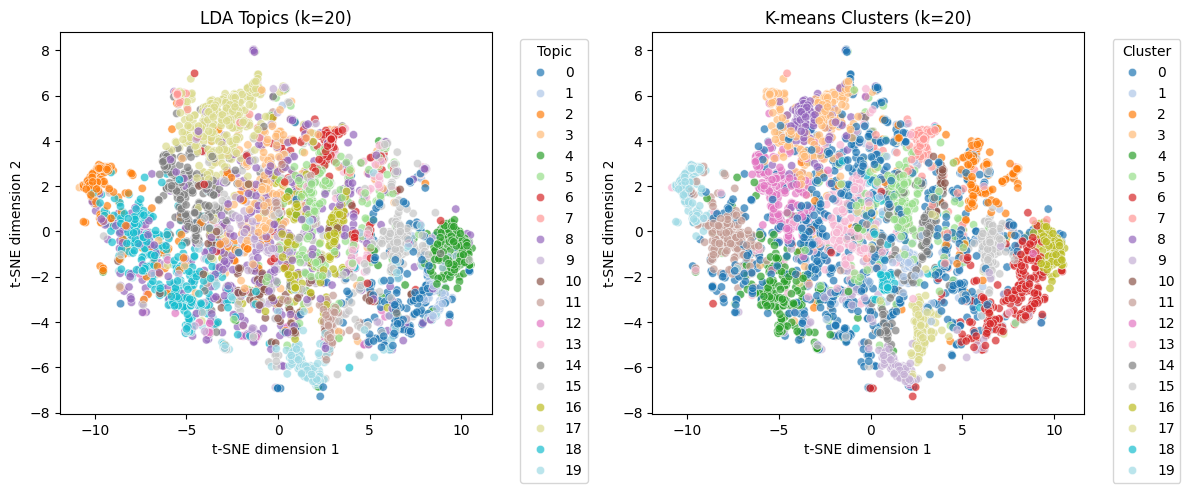

In [49]:
# Select the best models based on metrics
# For LDA, use coherence score
best_lda_k = 20
best_lda = lda_results[best_lda_k]['model']
print(f"Best LDA model: {best_lda_k} topics, coherence: {lda_results[best_lda_k]['coherence']:.4f}")

# For K-means, use silhouette score
best_kmeans_k = 20
best_kmeans = kmeans_results[best_kmeans_k]['model']
print(f"Best K-means model: {best_kmeans_k} clusters, silhouette: {kmeans_results[best_kmeans_k]['silhouette']:.4f}")

# Get document classifications
lda_output = best_lda.transform(count_matrix)
lda_dominant_topic = np.argmax(lda_output, axis=1)

kmeans_labels = best_kmeans.labels_

# Visualization of document clusters/topics using t-SNE
print("\nVisualizing document clusters using t-SNE...")

# Create a t-SNE embedding of the TF-IDF matrix
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_embedding = tsne.fit_transform(X_normalized.toarray())

# Create a DataFrame for plotting
viz_df = pd.DataFrame(tsne_embedding, columns=['x', 'y'])
viz_df['LDA_Topic'] = lda_dominant_topic
viz_df['KMeans_Cluster'] = kmeans_labels

# Plot the LDA topics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=viz_df, x='x', y='y', hue='LDA_Topic', palette='tab20', legend='brief', alpha=0.7)
plt.title(f'LDA Topics (k={best_lda_k})')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1, 2, 2)
sns.scatterplot(data=viz_df, x='x', y='y', hue='KMeans_Cluster', palette='tab20', legend='brief', alpha=0.7)
plt.title(f'K-means Clusters (k={best_kmeans_k})')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Comparing LDA Topics vs. K-means Clusters (t-SNE Visualization)

#### LDA Topics (Left Image)
- **Distribution pattern**: More overlapping groups
- **Boundary definition**: Topics blend into each other with significant overlap
- **Clustering tendency**: Some visible concentrations (like the light green cluster at the right), but generally more integrated
- **Topic coherence**: Multiple colors appear throughout the space, showing documents belonging to multiple topics

#### K-means Clusters (Right Image)
- **Distribution pattern**: More distinct groupings with clearer boundaries
- **Boundary definition**: Several well-defined clusters, particularly around the edges
- **Clustering tendency**: Stronger grouping of similar colors, especially visible for clusters 6 (red) and 4 (green)
- **Topic coherence**: Less mixing of colors, reflecting the hard assignment nature of K-means

#### Interpretation

This visualization effectively demonstrates the fundamental difference between these methods:

1. **LDA's probabilistic approach** allows documents to belong to multiple topics, resulting in a more blended visualization where boundaries are fuzzy. This reflects how real text data often contains multiple themes.

2. **K-means' distance-based approach** forces documents into a single cluster, creating more visually distinct groupings. This works well for organizing content into clear categories.

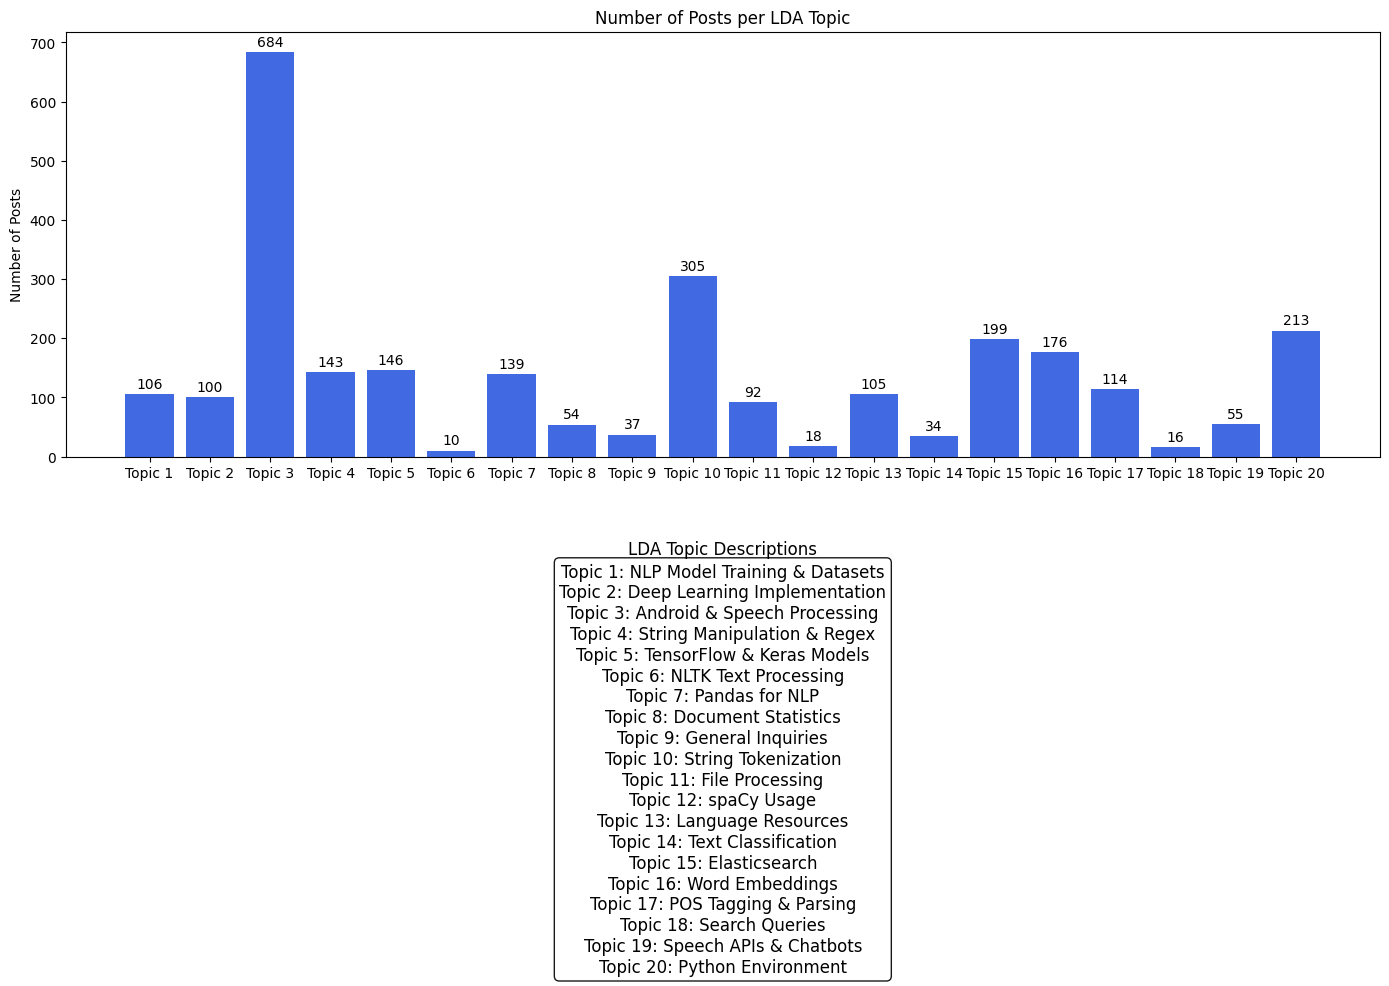

In [ ]:
# Get topic distribution for each document
lda_output = lda_model.transform(count_matrix)

# Assign dominant topic to each document
dominant_topic = np.argmax(lda_output, axis=1)

# Count documents per topic
topic_counts = pd.Series(dominant_topic).value_counts().sort_index()

# Make sure we have counts for all topics (some might have 0 documents)
all_counts = pd.Series(0, index=range(20))  # Assuming 20 topics
all_counts.update(topic_counts)

# Create the plot
topic_names = [
    "NLP Model Training & Datasets",
    "Deep Learning Implementation",
    "Android & Speech Processing",
    "String Manipulation & Regex",
    "TensorFlow & Keras Models",
    "NLTK Text Processing",
    "Pandas for NLP",
    "Document Statistics",
    "General Inquiries",
    "String Tokenization",
    "File Processing",
    "spaCy Usage",
    "Language Resources",
    "Text Classification",
    "Elasticsearch",
    "Word Embeddings",
    "POS Tagging & Parsing",
    "Search Queries",
    "Speech APIs & Chatbots",
    "Python Environment"
]

# Create figure with two subplots (stacked vertically)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 2]})

# Top subplot: Bar chart of post counts
bars = ax1.bar(range(len(topic_names)), all_counts, color='royalblue')
ax1.set_xticks(range(len(topic_names)))
ax1.set_xticklabels([f"Topic {i+1}" for i in range(len(topic_names))])
ax1.set_title('Number of Posts per LDA Topic')
ax1.set_ylabel('Number of Posts')

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{int(height)}', ha='center', va='bottom')

# Bottom subplot: Topic descriptions
ax2.axis('off')  # Hide axes
topic_text = "\n".join([f"Topic {i+1}: {topic_names[i]}" for i in range(len(topic_names))])
ax2.text(0.5, 1.0, topic_text, ha='center', va='top', fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
ax2.set_title('LDA Topic Descriptions')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # Add space between subplots
plt.show()

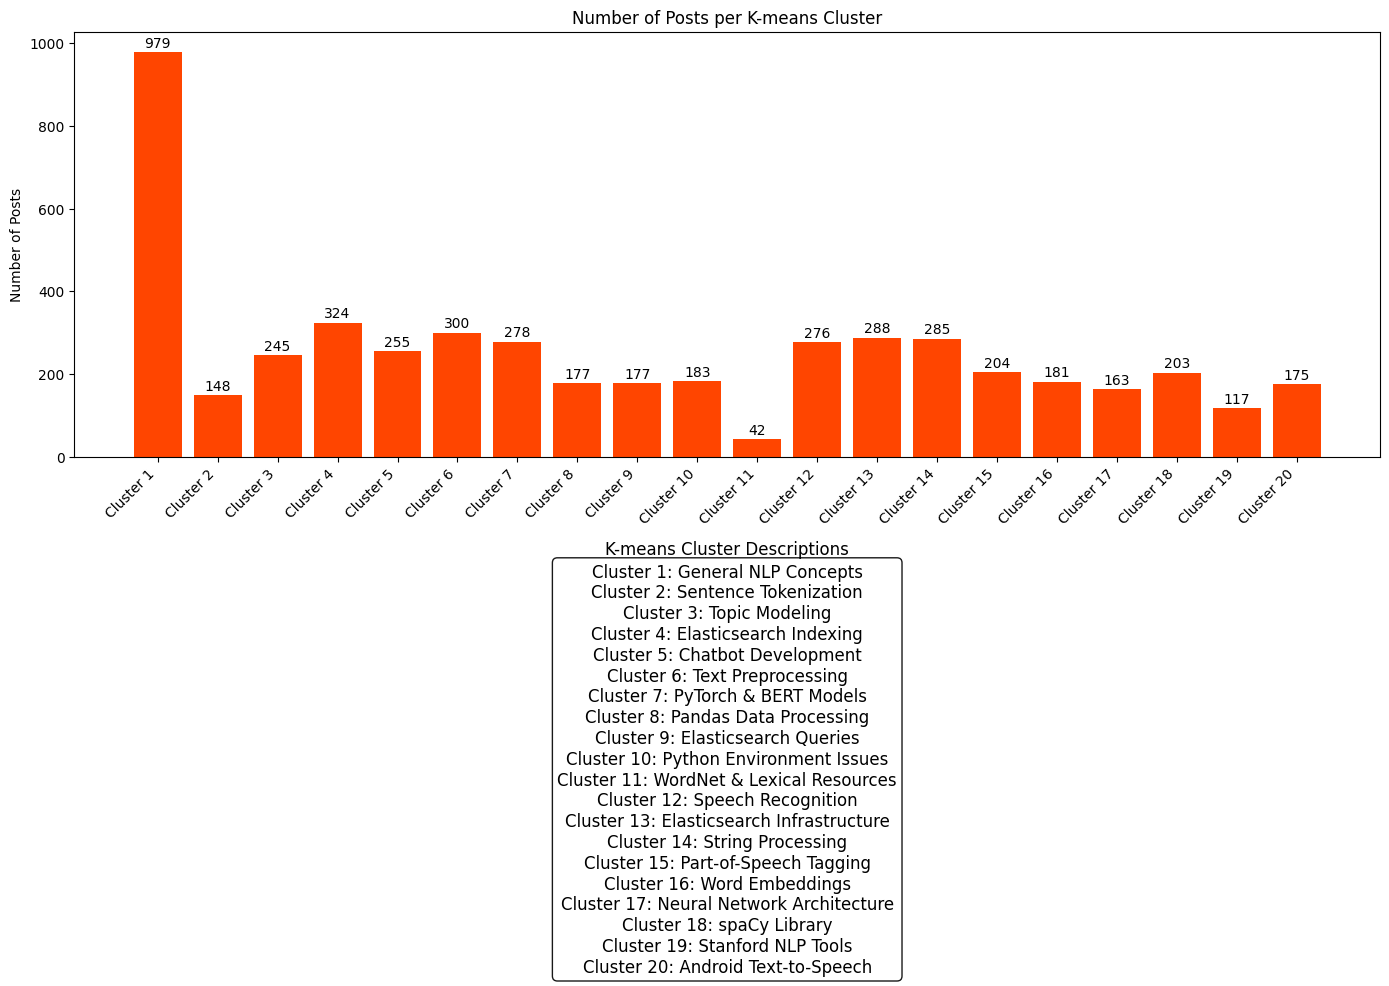

In [58]:
# Accesing K-means model and getting the counts
kmeans_model = kmeans_results[20]['model']
kmeans_labels = kmeans_model.labels_
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
all_counts = pd.Series(0, index=range(20))
all_counts.update(cluster_counts)

# K-means cluster names
kmeans_topics = [
    "General NLP Concepts",
    "Sentence Tokenization",
    "Topic Modeling",
    "Elasticsearch Indexing",
    "Chatbot Development",
    "Text Preprocessing",
    "PyTorch & BERT Models",
    "Pandas Data Processing",
    "Elasticsearch Queries",
    "Python Environment Issues",
    "WordNet & Lexical Resources",
    "Speech Recognition",
    "Elasticsearch Infrastructure",
    "String Processing",
    "Part-of-Speech Tagging",
    "Word Embeddings",
    "Neural Network Architecture",
    "spaCy Library",
    "Stanford NLP Tools",
    "Android Text-to-Speech"
]

# Create figure with two subplots (stacked vertically)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 2]})

# Top subplot: Bar chart of post counts
bars = ax1.bar(range(len(kmeans_topics)), all_counts, color='orangered')
ax1.set_xticks(range(len(kmeans_topics)))
ax1.set_xticklabels([f"Cluster {i+1}" for i in range(len(kmeans_topics))])
ax1.set_title('Number of Posts per K-means Cluster')
ax1.set_ylabel('Number of Posts')
ax1.set_xticklabels([f"Cluster {i+1}" for i in range(len(kmeans_topics))], rotation=45, ha='right')

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{int(height)}', ha='center', va='bottom')

# Bottom subplot: Cluster descriptions
ax2.axis('off')  # Hide axes
cluster_text = "\n".join([f"Cluster {i+1}: {kmeans_topics[i]}" for i in range(len(kmeans_topics))])
ax2.text(0.5, 1.0, cluster_text, ha='center', va='top', fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
ax2.set_title('K-means Cluster Descriptions')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # Add space between subplots
plt.show()

#### Which is Better?

 **We choose Regex if**:
 - We are able to identify predetermined patterns
 - But it can miss posts which are semantically similar

 **We choose LDA if**:
 - We want to understand how topics overlap and relate to each other
 - it allows documents to belong to multiple topics simultaneously
 - Topics may become hard to interpret

 **We choose K-means if**:
 - We need clear categorization for organization or retrieval
 - Forces everything to belong to one category
 - Can ovesimplify by assigning generic topics to each document

LDA discovers latent topics probabilistically, K-means groups similar documents based on term frequency, while regex directly identifies specific predefined patterns. For Stack Overflow NLP questions, a hybrid approach might be optimal, using regex for clearly defined categories and LDA/K-means for broader thematic organization.